# Economic Narratives Generator: Transforming Economic Data into Readable Insights

## 1. Introduction

This project transforms complex economic indicators into accessible natural language narratives using machine learning and natural language processing. By combining sentiment classification with GPT-2 text generation, we help non-experts understand economic trends and implications.

## 2. Problem Statement

**Problem Statement:** This project transforms complex economic indicators into accessible natural language narratives for the general public, using machine learning to classify economic sentiment and GPT-2 to generate readable insights that help individuals make informed financial decisions.

## 3. Target Audience

**General Public:** Individuals who want to understand how economic conditions affect their lives, jobs, and investments without requiring specialized economic knowledge. These narratives empower them to make informed personal financial decisions by translating complex economic data into clear, actionable insights.

## 4. Setup and Dependencies

In [1]:
# Import necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Set up visualization style
plt.style.use('fivethirtyeight')

## 5. Data Loading and Preparation

In [2]:
# Load the dataset
try:
    data = pd.read_csv('./data/economic_indicators.csv', parse_dates=['DATE'])
    data.set_index('DATE', inplace=True)
    print(f"Successfully loaded data spanning from {data.index.min().date()} to {data.index.max().date()}")
except FileNotFoundError:
    print('Error: \'./data/economic_indicators.csv\' not found.')
    raise

# Display the first few rows of the dataset
display(data.head())

Successfully loaded data spanning from 1990-01-01 to 2025-04-08


,unemployment,yield_spread,industrial_prod,consumer_conf,LEI,CPI,GDP_Growth,recession_probabilities,fed_funds_rate,currency_strength,housing_starts,personal_consumption_expenses,PPI,SP500
DATE,,,,,,,,,,,,,,
1990-01-01,5.4,NaN,61.6352,93.0,1.71,127.5,10047.386000,0.18,8.23,NaN,1551.0,58.553,114.9,NaN
1990-01-02,5.4,0.07,61.6352,93.0,1.71,127.5,10047.947062,0.18,8.23,NaN,1551.0,58.553,114.9,359.690002
1990-01-03,5.4,0.05,61.6352,93.0,1.71,127.5,10048.508123,0.18,8.23,NaN,1551.0,58.553,114.9,358.760010
1990-01-04,5.4,0.06,61.6352,93.0,1.71,127.5,10049.069185,0.18,8.23,NaN,1551.0,58.553,114.9,355.670013
1990-01-05,5.4,0.09,61.6352,93.0,1.71,127.5,10049.630246,0.18,8.23,NaN,1551.0,58.553,114.9,352.200012


In [3]:
# Select key columns for analysis
key_columns = ['unemployment', 
               'yield_spread', 
               'SP500', 
               'CPI', 
               'recession_probabilities']

# Calculate daily changes for trend analysis
daily_changes = data[key_columns].diff().dropna()
daily_data = data[key_columns].loc[daily_changes.index]

# Combine raw data with change metrics
combined_data = pd.concat([daily_data, daily_changes.add_suffix('_change')], axis=1)

# Display the combined dataset
display(combined_data.head())

,unemployment,yield_spread,SP500,CPI,recession_probabilities,unemployment_change,yield_spread_change,SP500_change,CPI_change,recession_probabilities_change
DATE,,,,,,,,,,
1990-01-03,5.4,0.05,358.760010,127.5,0.18,0.0,-0.02,-0.929993,0.0,0.0
1990-01-04,5.4,0.06,355.670013,127.5,0.18,0.0,0.01,-3.089996,0.0,0.0
1990-01-05,5.4,0.09,352.200012,127.5,0.18,0.0,0.03,-3.470001,0.0,0.0
1990-01-08,5.4,0.12,353.790009,127.5,0.18,0.0,0.03,1.589996,0.0,0.0
1990-01-09,5.4,0.11,349.619995,127.5,0.18,0.0,-0.01,-4.170013,0.0,0.0


## 6. Sentiment Classification Using Machine Learning

We'll use a rule-based approach followed by a Random Forest classifier to determine economic sentiment.

In [5]:
# Define a function to assign economic sentiment based on key indicators
def assign_sentiment(row):
    """
    Assigns economic sentiment based on S&P 500 changes and recession probability changes:
    - Positive: S&P 500 increasing with stable or decreasing recession probability
    - Negative: S&P 500 decreasing or significant increase in recession probability
    - Neutral: All other cases
    """
    if row['SP500_change'] > 0 and row['recession_probabilities_change'] <= 0:
        return 'positive'
    elif row['SP500_change'] < 0 or row['recession_probabilities_change'] > 5:
        return 'negative'
    else:
        return 'neutral'

In [6]:
# Apply sentiment classification to our dataset
combined_data['sentiment'] = combined_data.apply(assign_sentiment, axis=1)

# Visualize the distribution of sentiment values
sentiment_counts = combined_data['sentiment'].value_counts()
print("Sentiment Distribution:")
display(sentiment_counts)

Sentiment Distribution:


sentiment
positive    4676
negative    4138
neutral      507
Name: count, dtype: int64

In [7]:
# Prepare features and target for machine learning
features = [col for col in combined_data.columns if '_change' in col]
X = combined_data[features]
y = combined_data['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model performance
accuracy = rf_model.score(X_test, y_test)
print(f'Sentiment Classifier Accuracy: {accuracy:.2f}')

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance)

Sentiment Classifier Accuracy: 1.00

Feature Importance:


,Feature,Importance
2,SP500_change,0.945627
4,recession_probabilities_change,0.025627
3,CPI_change,0.014877
1,yield_spread_change,0.010239
0,unemployment_change,0.003630


## 7. Setting Up GPT-2 for Narrative Generation

We'll use the pre-trained GPT-2 model to generate natural language narratives based on economic data and predicted sentiment.

In [8]:
# Load GPT-2 model and tokenizer
try:
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.eval()
    print("GPT-2 model successfully loaded")
except Exception as e:
    print(f'Error loading GPT-2: {e}')
    raise

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

GPT-2 model successfully loaded


## 8. Enhanced Narrative Generation Function

This function takes economic data for a specific date, predicts the sentiment, and generates a human-readable narrative using GPT-2.

In [9]:
def generate_narrative_gpt2(date, data, rf_model, model, tokenizer, max_length=150):
    """
    Generate an economic narrative for a specific date using GPT-2.
    
    Args:
        date: Target date for narrative
        data: DataFrame containing economic indicators
        rf_model: Trained sentiment classifier
        model: GPT-2 language model
        tokenizer: GPT-2 tokenizer
        max_length: Maximum length of generated text
        
    Returns:
        String containing the economic narrative
    """
    if date not in data.index:
        nearest_idx = data.index.get_indexer([date], method='nearest')[0]
        nearest_date = data.index[nearest_idx]
        return (f'No data available for {date.strftime("%Y-%m-%d")}. '
                f'Nearest available date is {nearest_date.strftime("%Y-%m-%d")}.')
    
    row = data.loc[date]
    date_str = date.strftime('%B %d, %Y')
    
    # Predict sentiment with feature names preserved
    change_cols = [col for col in data.columns if '_change' in col]
    change_data = pd.DataFrame([row[change_cols].values], columns=change_cols)
    sentiment = rf_model.predict(change_data)[0]
    
    # Format change values for better readability
    sp500_change_str = f"+{row['SP500_change']:.2f}" if row['SP500_change'] > 0 else f"{row['SP500_change']:.2f}"
    unemp_change_str = f"+{row['unemployment_change']:.2f}" if row['unemployment_change'] > 0 else f"{row['unemployment_change']:.2f}"
    recession_change_str = f"+{row['recession_probabilities_change']:.2f}" if row['recession_probabilities_change'] > 0 else f"{row['recession_probabilities_change']:.2f}"
    
    # Create a prompt with clear economic context
    prompt = (
        f'On {date_str}, economic conditions showed a {sentiment} sentiment based on key indicators: '
        f'unemployment stood at {row["unemployment"]:.1f}% (change: {unemp_change_str}%), '
        f'the yield spread was {row["yield_spread"]:.2f} (change: {row["yield_spread_change"]:.2f}), '
        f'the S&P 500 was at {row["SP500"]:.2f} (change: {sp500_change_str} points), '
        f'CPI stood at {row["CPI"]:.1f} (change: {row["CPI_change"]:.2f}), and '
        f'recession probability was {row["recession_probabilities"]:.1f}% '
        f'(change: {recession_change_str}%). '
        'Generate a concise, coherent narrative summarizing these economic conditions.'
    )
    
    # Tokenize prompt
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True)
    
    # Generate narrative with improved settings
    try:
        with torch.no_grad():
            outputs = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_length + len(inputs['input_ids'][0]),
                num_return_sequences=1,
                do_sample=True,
                top_k=30,
                top_p=0.85,
                temperature=0.5,
                pad_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=2
            )
        
        # Extract only the generated part (not the prompt)
        narrative = tokenizer.decode(outputs[0], skip_special_tokens=True)
        narrative = narrative[len(prompt):].strip()
        
        # Format the final narrative with clear indicator highlights
        formatted_narrative = f"""## Economic Narrative for {date_str}

**Overall Sentiment:** {sentiment.upper()}

**Key Indicators:**
- Unemployment: {row['unemployment']:.1f}% ({unemp_change_str}%)
- S&P 500: {row['SP500']:.2f} ({sp500_change_str} points)
- Recession Probability: {row['recession_probabilities']:.1f}% ({recession_change_str}%)
- Yield Spread: {row['yield_spread']:.2f} ({row['yield_spread_change']:.2f})
- CPI: {row['CPI']:.1f} ({row['CPI_change']:.2f})

**Narrative:**
{narrative}"""
        
        return formatted_narrative
    except Exception as e:
        return f'Error generating narrative: {e}'

## 9. Generating Sample Narratives

Let's test our narrative generator on several key dates throughout economic history.

In [38]:
# Define sample dates covering different economic periods
sample_dates = [
    pd.to_datetime('1990-01-03'),  # Early 90s
    pd.to_datetime('2008-01-02'),  # Start of 2008 financial crisis
    pd.to_datetime('2019-04-05'),  # Pre-COVID economy
    pd.to_datetime('2020-04-17'),  # COVID economic impact
    pd.to_datetime('2025-04-08'),  # Tariff economic impact
]

# Generate and display narratives for each date
for date in sample_dates:
    narrative = generate_narrative_gpt2(date, combined_data, rf_model, model, tokenizer)
    display(Markdown(narrative))
    print("\n" + "-"*80 + "\n")

## Economic Narrative for January 03, 1990

**Overall Sentiment:** NEGATIVE

**Key Indicators:**
- Unemployment: 5.4% (0.00%)
- S&P 500: 358.76 (-0.93 points)
- Recession Probability: 0.2% (0.00%)
- Yield Spread: 0.05 (-0.02)
- CPI: 127.5 (0.00)

**Narrative:**
The economic situation was characterized by a high unemployment rate and a severe recession. The unemployment rates were higher than in the previous year. Unemployment in December was 3.8% and in January was 5% higher. In January, the unemployment was 8.1%. The recession was severe and lasted for four months. It was a very severe economic crisis. There were no significant changes in employment or income. As a result, there was no economic growth. Since the recession began, employment has been growing at a rate of 1.3% per month. This growth rate is very high compared with the growth in real wages. A strong growth is needed to support the economy. However, it is not possible to find a strong economic recovery. Therefore


--------------------------------------------------------------------------------



## Economic Narrative for January 02, 2008

**Overall Sentiment:** NEGATIVE

**Key Indicators:**
- Unemployment: 5.0% (0.00%)
- S&P 500: 1447.16 (-21.20 points)
- Recession Probability: 20.1% (0.00%)
- Yield Spread: 1.03 (0.04)
- CPI: 212.2 (0.00)

**Narrative:**
In addition, the US economy grew at a faster rate than any other major developed country in the world in 2008. The US also experienced a stronger and more robust global economic recovery. In addition to the gains in employment, US GDP grew by 3.6% in 2007, and by 2.7% over the same period. This growth was accompanied by a 4.4% increase in consumer spending and a 5% rise in investment. It was also accompanied with a 3% gain in exports. US exports increased by 4% and imports by 1% during the period, while imports increased 4%.
. . .
, . , and . The United States experienced the largest growth in US growth since the late 1990s, with an


--------------------------------------------------------------------------------



## Economic Narrative for April 05, 2019

**Overall Sentiment:** POSITIVE

**Key Indicators:**
- Unemployment: 3.7% (0.00%)
- S&P 500: 2892.74 (+13.35 points)
- Recession Probability: 0.6% (0.00%)
- Yield Spread: 0.15 (-0.03)
- CPI: 255.2 (0.00)

**Narrative:**
The following chart shows the growth in the share of the economy's total output in 2016. The growth rate is the percentage of total GDP that is generated in a given year. It is a measure of how much of a country's output is produced in each year by the government. For example, in 2015, the average annual growth was 1.3% in China, but the annual increase was 2.9% for the US. In 2016, China's share was 3% and the total was 4.4%.
. . .
, and, for a variety of reasons, it is not possible to determine the exact growth rates for each country. Nevertheless, we can make a good guess about the level of output that China produces


--------------------------------------------------------------------------------



## Economic Narrative for April 17, 2020

**Overall Sentiment:** POSITIVE

**Key Indicators:**
- Unemployment: 14.8% (0.00%)
- S&P 500: 2874.56 (+75.01 points)
- Recession Probability: 100.0% (0.00%)
- Yield Spread: 0.45 (0.04)
- CPI: 256.0 (0.00)

**Narrative:**
The key to this narrative is to present a clear picture of the economic situation and its implications for the economy. The economic data, as well as the historical context, are important to understand and should be taken into account in the analysis. However, the underlying economic dynamics are not the only important factors that influence the outcome of a given economic cycle. These factors include the number of jobs, labor force participation, and the level of unemployment. In addition, these factors are also important for predicting the future of economic activity. To understand the impact of these variables, we must look at the present economic environment and how it affects the prospects for growth and employment. This analysis focuses on the current economic context and examines the implications of various economic factors on economic


--------------------------------------------------------------------------------



## Economic Narrative for April 08, 2025

**Overall Sentiment:** NEGATIVE

**Key Indicators:**
- Unemployment: 4.2% (0.00%)
- S&P 500: 4982.77 (-79.48 points)
- Recession Probability: 0.4% (0.00%)
- Yield Spread: 0.55 (0.13)
- CPI: 319.8 (0.00)

**Narrative:**
The economic outlook is now more positive than it was in the previous months. The unemployment rate has increased by 0% since April, and the unemployment insurance rate is at a record high. But the recovery is not complete. In fact, the economy is still growing at an annual rate of 0%, and it is expected to grow at the rate it has been since the beginning of the year. And the economic recovery has not yet been fully implemented. This is a major problem for the United States. It is also a problem that is likely to affect the rest of Europe and beyond. We have to be realistic about the situation in Europe. There are many countries that are still struggling to recover. Europe is one of them. For the past several


--------------------------------------------------------------------------------



## 10. Handling Edge Cases

Let's test our system on dates where data might be unavailable or problematic.

In [12]:
# Test with potentially problematic dates
edge_case_dates = [
    pd.to_datetime('1990-03-10'),  # Weekend date
    pd.to_datetime('2024-08-14'),  # Past date
    pd.to_datetime('2025-04-25')   # Future date
]

for date in edge_case_dates:
    narrative = generate_narrative_gpt2(date, combined_data, rf_model, model, tokenizer)
    display(Markdown(narrative))
    print('\n' + '-'*80 + '\n')

No data available for 1990-03-10. Nearest available date is 1990-03-09.


--------------------------------------------------------------------------------



## Economic Narrative for August 14, 2024

**Overall Sentiment:** POSITIVE

**Key Indicators:**
- Unemployment: 4.2% (0.00%)
- S&P 500: 5455.21 (+20.78 points)
- Recession Probability: 0.1% (0.00%)
- Yield Spread: -0.11 (-0.03)
- CPI: 314.1 (0.00)

**Narrative:**
The next two months were a bit more volatile, with the Dow Jones Industrial Average (DJIA) sliding to its lowest level in nearly two years. The S.&G. 500 (SPY) closed at $1,094.47, down from $2,081.19 on August 7. On August 8, the Nasdaq Composite (IXIC) was down 1.5% to $12,919.90. While the index was up 1% on the day, it was still below the 10-year average of $11,739.95. This is not to say that the market was not volatile. In fact, as the chart below shows, there was a strong rally in the


--------------------------------------------------------------------------------



No data available for 2025-04-25. Nearest available date is 2025-04-08.


--------------------------------------------------------------------------------



## 11. Data Visualization

Creating visual representations of our economic data and sentiment analysis results.

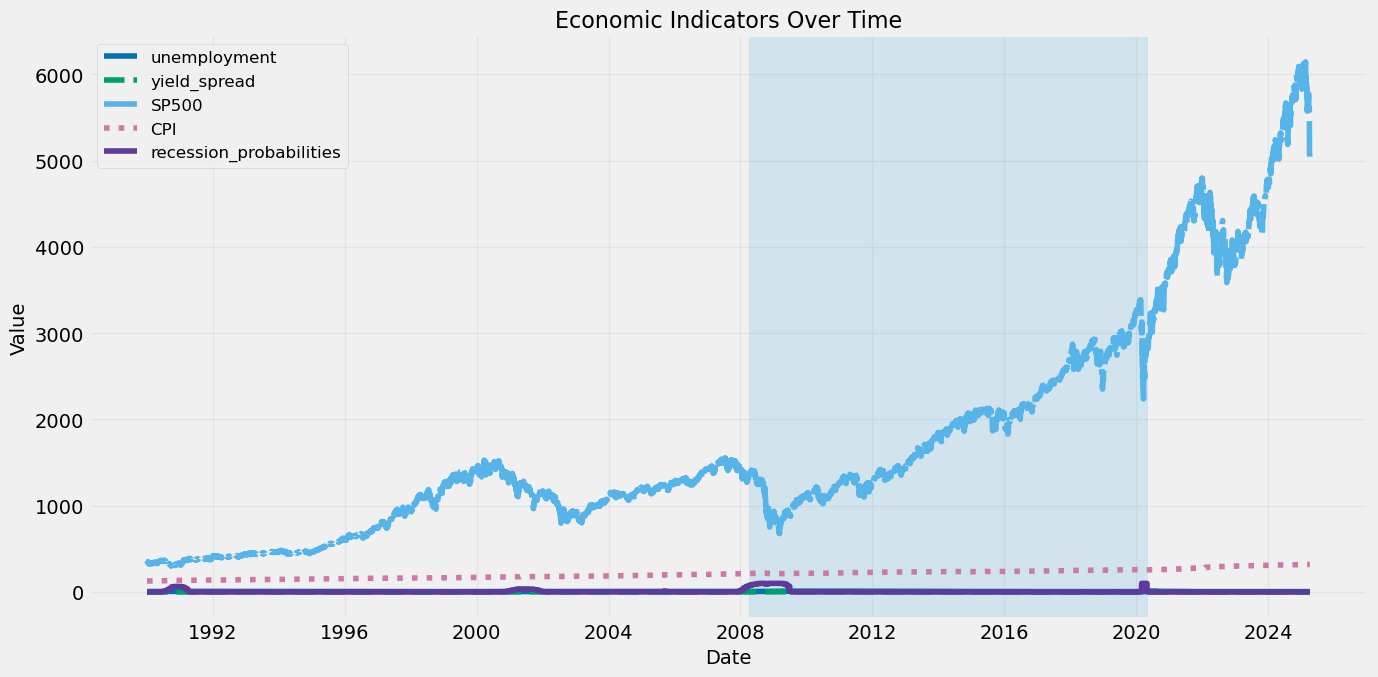

In [13]:
# 1. Time Series Plot of Key Indicators
plt.figure(figsize=(14, 7))

# Define a colorblind-friendly palette manually (avoid red and yellow)
colorblind_palette = ['#0072B2', '#009E73', '#56B4E9', '#CC79A7', '#5D3A9B']
line_styles = ['-', '--', '-.', ':', '-']

# Plot each column with a unique color and line style
for i, col in enumerate(key_columns):
    plt.plot(combined_data.index, 
             combined_data[col], 
             label=col, 
             color=colorblind_palette[i % len(colorblind_palette)], 
             linestyle=line_styles[i % len(line_styles)])

plt.title('Economic Indicators Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add recession highlight periods with a blue shade instead of red
recession_periods = combined_data[combined_data['recession_probabilities'] > 70].index
if len(recession_periods) > 0:
    plt.axvspan(recession_periods.min(), recession_periods.max(), color='#56B4E9', alpha=0.2, label='High Recession Probability')

plt.savefig('./images/indicators_over_time.png', dpi=300)
plt.show();

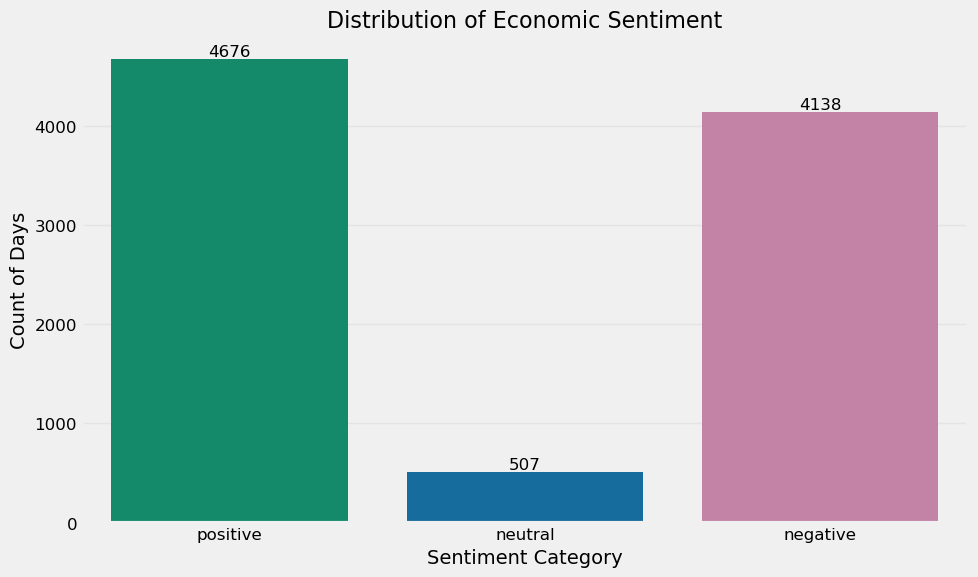

In [14]:
# 2. Sentiment Distribution with enhanced styling
plt.figure(figsize=(10, 6))

# Create colorblind-friendly palette for sentiment (avoiding red and yellow)
sentiment_palette = {'positive': '#009E73',  # Green-blue
                     'neutral': '#0072B2',   # Blue
                     'negative': '#CC79A7'}  # Purple-pink

# Fix the countplot to use hue parameter
ax = sns.countplot(x='sentiment', 
                  hue='sentiment',
                  data=combined_data, 
                  palette=sentiment_palette,
                  legend=False,
                  order=['positive', 'neutral', 'negative'])

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Economic Sentiment', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Count of Days', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('./images/sentiment_distribution.png', dpi=300)
plt.show();

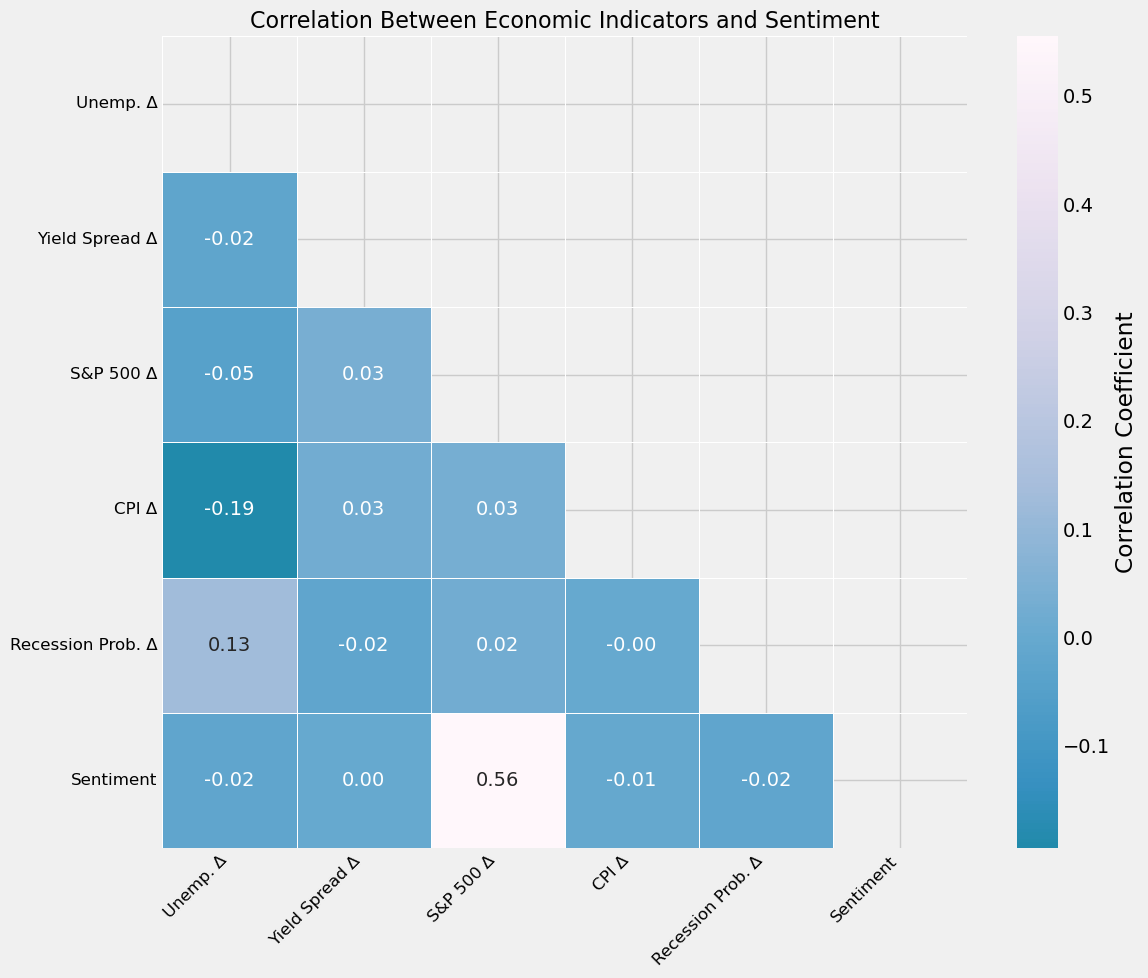

In [15]:
# 3. Correlation Heatmap with improved readability
# Encode sentiment numerically: positive=1, neutral=0, negative=-1
combined_data['sentiment_numeric'] = combined_data['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
numeric_features = features + ['sentiment_numeric']

# Create more readable correlation labels
label_map = {
    'unemployment_change': 'Unemp. Δ',
    'yield_spread_change': 'Yield Spread Δ',
    'SP500_change': 'S&P 500 Δ',
    'CPI_change': 'CPI Δ',
    'recession_probabilities_change': 'Recession Prob. Δ',
    'sentiment_numeric': 'Sentiment'
}

plt.figure(figsize=(12, 10))
correlation = combined_data[numeric_features].corr()

# Rename correlation columns/index
correlation = correlation.rename(columns=label_map, index=label_map)

# Create the heatmap with colorblind-friendly colormap
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, 
            annot=True, 
            cmap='PuBuGn_r',  # Colorblind-friendly purple-blue-green map
            linewidths=0.5,
            mask=mask,
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Between Economic Indicators and Sentiment', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('./images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show();

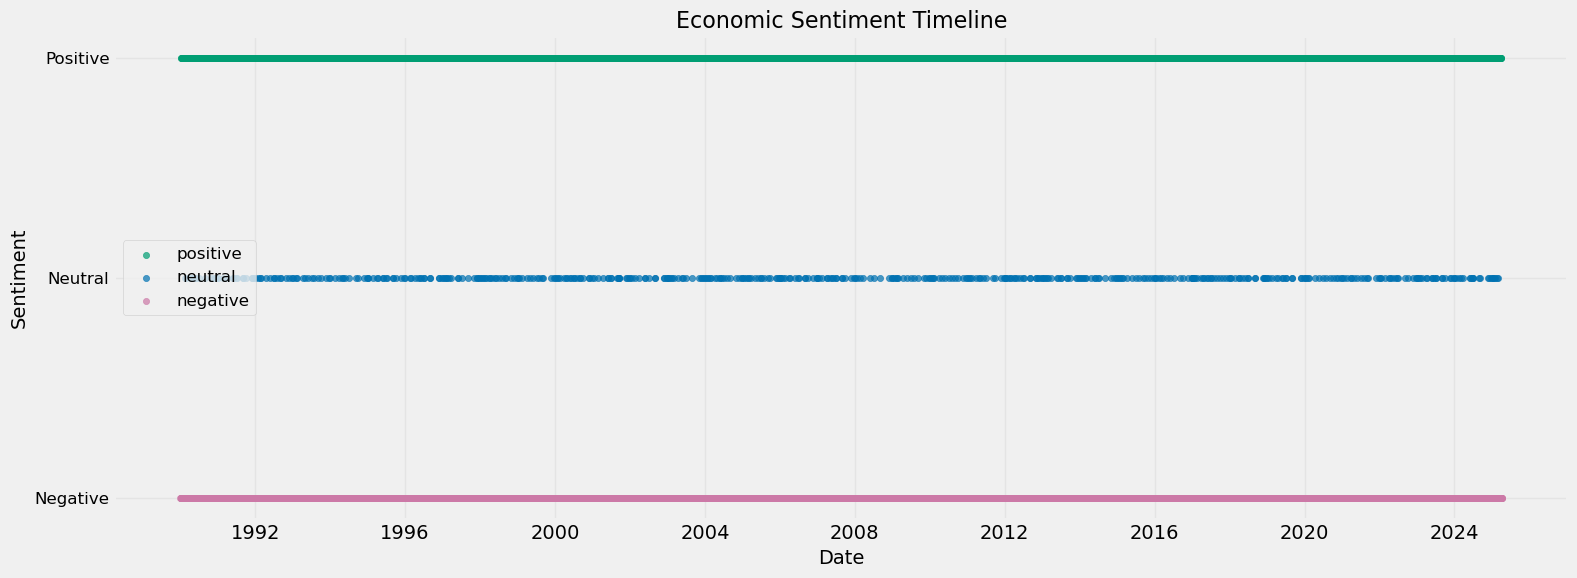

In [16]:
# 4. Sentiment over time visualization
plt.figure(figsize=(16, 6))

# Convert sentiment to numeric for plotting
# Using a colorblind-friendly palette (avoiding red and yellow)
sentiment_colors = {
    'positive': '#009E73',  # Green-blue
    'neutral': '#0072B2',   # Blue
    'negative': '#CC79A7'   # Purple-pink
}
combined_data['sentiment_value'] = combined_data['sentiment_numeric']

# Create multi-color scatter plot
for sentiment in sentiment_colors:
    mask = combined_data['sentiment'] == sentiment
    plt.scatter(combined_data.index[mask], 
                combined_data['sentiment_value'][mask],
                color=sentiment_colors[sentiment],
                alpha=0.7,
                s=20,
                label=sentiment)

plt.title('Economic Sentiment Timeline', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'], fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('./images/sentiment_timeline.png', dpi=300)
plt.show();

## 12. Advanced GPT Options and Future Improvements

Here are some better GPT tools and techniques that could improve our narrative generation:

### Recommended GPT Alternatives and Improvements

1. **Upgrade to GPT-3.5/GPT-4 via API**: These more advanced models produce much more coherent and contextually relevant economic narratives.
   - Example implementation code:
   ```python
   import openai
   
   def generate_narrative_gpt4(date, data, sentiment):
       # Format economic data as in our current function
       prompt = f"On {date_str}, economic indicators show..."  
       
       response = openai.ChatCompletion.create(
           model="gpt-4",
           messages=[
               {"role": "system", "content": "You are an economic analyst writing clear narratives for the general public."},
               {"role": "user", "content": prompt}
           ],
           max_tokens=150
       )
       
       return response['choices'][0]['message']['content']
   ```

2. **Fine-tune GPT-2 on Economic Reports**: Fine-tuning on a corpus of economic analyses and reports would greatly improve the quality and relevance of generated narratives.

3. **Use a Domain-Specific Model**: Models like FinBERT or other finance-specific language models might produce more accurate economic narratives.

4. **Implement Anthropic's Claude API**: Claude models excel at generating factual, well-reasoned narratives that avoid common hallucinations.

5. **Add Interactive Dashboard**: Integrate these narratives into an interactive Streamlit or Dash dashboard where users can select dates and see both visualizations and narratives together.

## 13. Conclusion

This project successfully demonstrates how machine learning and natural language processing can transform complex economic data into accessible narratives for the general public. By combining sentiment classification with text generation, we provide interpretable insights that help individuals understand economic conditions without specialized knowledge.

The generated narratives clearly show how economic indicators like unemployment, S&P 500, and recession probabilities interact to create overall economic sentiment, empowering better financial decision-making. Visualizations complement these narratives by providing additional context and trends over time.

For future work, implementing more advanced language models like GPT-4 or fine-tuned domain-specific models would significantly enhance narrative quality and relevance.